In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
"""
Testing environment with stable_baselines3 library
"""
import sys
sys.path.append('../')

from stable_baselines3.common.env_checker import check_env
from envs.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

env = BatteryStorageInGridEnv()

check_env(env)

step:  2
gen max production:  [ 3.14815044  4.18503482  4.27281036  6.286753    6.87389133  6.00996748
 11.88114821 12.06456408 12.19546951 12.25575679]
load:  3.5665
status:  optimal


/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
"""
Testing RL agent which randomly chooses actions
"""
import sys
sys.path.append('../')
from typing import List
import numpy as np
import os
import pandas as pd
import gym

from tqdm import tqdm
import matplotlib.pyplot as plt

env = BatteryStorageInGridEnv()

episodes = 100

rewards_lst_1 = []

for i in tqdm(range(episodes)):
    ob = env.reset()
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)

    while not done:
        # random action as policy
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    # print("episode {} mean reward: {}".format(i, np.mean(rewards)))
    rewards_lst_1.append(np.sum(rewards))

# print(rewards_lst_1)
# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_1, width=0.5)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

step:  2
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.582333333333333
status:  optimal
step:  3
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5613333333333332
status:  optimal
step:  4
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5563333333333333
status:  optimal
step:  5
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.534666666666667
status:  optimal
step:  6
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5228333333333333
status:  optimal
step:  7
gen max production

  1%|          | 1/100 [00:00<01:18,  1.26it/s]

status:  optimal
step:  222
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.864333333333333
status:  optimal
step:  223
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.881666666666667
status:  optimal
step:  224
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8991666666666664
status:  optimal
step:  225
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9143333333333334
status:  optimal
step:  226
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.924
status:  optimal
step:  227
ge

  2%|▏         | 2/100 [00:01<01:17,  1.26it/s]

status:  optimal
step:  233
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7565
status:  optimal
step:  234
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7853333333333334
status:  optimal
step:  235
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8063333333333333
status:  optimal
step:  236
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8281666666666667
status:  optimal
step:  237
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8518333333333334
status:  optimal
step:  238

  3%|▎         | 3/100 [00:02<01:16,  1.27it/s]

status:  optimal
step:  242
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.216666666666667
status:  optimal
step:  243
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.236
status:  optimal
step:  244
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.245166666666667
status:  optimal
step:  245
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.251833333333333
status:  optimal
step:  246
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.251
status:  optimal
step:  247
gen max producti

  4%|▍         | 4/100 [00:03<01:16,  1.26it/s]

status:  optimal
step:  251
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.039
status:  optimal
step:  252
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.031833333333333
status:  optimal
step:  253
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.028
status:  optimal
step:  254
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.038333333333333
status:  optimal
step:  255
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.028
status:  optimal
step:  256
gen max production:  [ 3.661

  5%|▌         | 5/100 [00:03<01:14,  1.27it/s]

status:  optimal
step:  265
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.341833333333334
status:  optimal
step:  266
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.3045
status:  optimal
step:  267
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.273833333333333
status:  optimal
step:  268
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.242
status:  optimal
step:  269
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.2195
status:  optimal
step:  270
gen max production:  [ 3.6

  6%|▌         | 6/100 [00:04<01:14,  1.27it/s]

status:  optimal
step:  272
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9966666666666666
status:  optimal
step:  273
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.967
status:  optimal
step:  274
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9371666666666667
status:  optimal
step:  275
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9093333333333335
status:  optimal
step:  276
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8925
status:  optimal
step:  277
gen max prod

  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

status:  optimal
step:  285
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.671666666666667
status:  optimal
step:  286
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.6555
status:  optimal
step:  287
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.633166666666667
status:  optimal
step:  288
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.6121666666666665
status:  optimal
step:  2
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.3918333333333335
status:  optimal
step:  3
gen m

  8%|▊         | 8/100 [00:06<01:12,  1.28it/s]

status:  optimal
step:  222
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5018333333333334
status:  optimal
step:  223
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5098333333333334
status:  optimal
step:  224
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.518666666666667
status:  optimal
step:  225
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.538
status:  optimal
step:  226
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5521666666666665
status:  optimal
step:  227
g

  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]

status:  optimal
step:  237
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.551166666666667
status:  optimal
step:  238
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.545833333333333
status:  optimal
step:  239
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.558666666666666
status:  optimal
step:  240
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.571666666666666
status:  optimal
step:  241
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.575166666666667
status:  optimal
ste

 10%|█         | 10/100 [00:07<01:10,  1.28it/s]

status:  optimal
step:  247
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.686333333333334
status:  optimal
step:  248
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.696166666666667
status:  optimal
step:  249
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.691166666666667
status:  optimal
step:  250
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.683
status:  optimal
step:  251
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.686
status:  optimal
step:  252
gen max producti

 11%|█         | 11/100 [00:08<01:09,  1.28it/s]

status:  optimal
step:  262
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.233666666666666
status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.209333333333333
status:  optimal
step:  264
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.177666666666667
status:  optimal
step:  265
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.152
status:  optimal
step:  266
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.119166666666667
status:  optimal
step:  267
gen 

 12%|█▏        | 12/100 [00:09<01:08,  1.28it/s]

step:  273
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.929666666666667
status:  optimal
step:  274
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8881666666666668
status:  optimal
step:  275
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8741666666666665
status:  optimal
step:  276
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8495
status:  optimal
step:  277
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8175
status:  optimal
step:  278
gen max production:  [ 3.6618

 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

status:  optimal
step:  281
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7108333333333334
status:  optimal
step:  282
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.6878333333333333
status:  optimal
step:  283
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.663666666666667
status:  optimal
step:  284
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.6506666666666665
status:  optimal
step:  285
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.623666666666667
status:  optimal


 14%|█▍        | 14/100 [00:11<01:07,  1.27it/s]

status:  optimal
step:  217
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.380166666666667
status:  optimal
step:  218
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.387333333333333
status:  optimal
step:  219
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.373666666666667
status:  optimal
step:  220
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.372333333333334
status:  optimal
step:  221
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.381
status:  optimal
step:  222
gen 

 15%|█▌        | 15/100 [00:11<01:06,  1.27it/s]

status:  optimal
step:  227
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4955
status:  optimal
step:  228
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5088333333333335
status:  optimal
step:  229
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.517333333333333
status:  optimal
step:  230
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5216666666666665
status:  optimal
step:  231
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.521333333333334
status:  optimal
step:  232
g

 16%|█▌        | 16/100 [00:12<01:05,  1.27it/s]

status:  optimal
step:  238
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.1033333333333335
status:  optimal
step:  239
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.124
status:  optimal
step:  240
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.151833333333333
status:  optimal
step:  241
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.168666666666667
status:  optimal
step:  242
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.1955
status:  optimal
step:  243
gen max produc

 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

status:  optimal
step:  249
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.654
status:  optimal
step:  250
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.644166666666667
status:  optimal
step:  251
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.638
status:  optimal
step:  252
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.624333333333333
status:  optimal
step:  253
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.626166666666666
status:  optimal
step:  254
gen max producti

 18%|█▊        | 18/100 [00:14<01:04,  1.27it/s]

status:  optimal
step:  258
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.462666666666666
status:  optimal
step:  259
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.457
status:  optimal
step:  260
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.443
status:  optimal
step:  261
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4078333333333335
status:  optimal
step:  262
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.375166666666667
status:  optimal
step:  263
gen max product

 19%|█▉        | 19/100 [00:14<01:04,  1.27it/s]

status:  optimal
step:  267
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.095
status:  optimal
step:  268
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0655
status:  optimal
step:  269
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.038666666666667
status:  optimal
step:  270
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.004666666666667
status:  optimal
step:  271
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9818333333333333
status:  optimal
step:  272
gen max produc

 20%|██        | 20/100 [00:15<01:03,  1.27it/s]

status:  optimal
step:  278
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8306666666666667
status:  optimal
step:  279
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7908333333333335
status:  optimal
step:  280
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7788333333333335
status:  optimal
step:  281
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7591666666666668
status:  optimal
step:  282
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.736666666666667
status:  optimal

 21%|██        | 21/100 [00:16<01:02,  1.27it/s]

status:  optimal
step:  2
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.3305
status:  optimal
step:  3
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.3143333333333334
status:  optimal
step:  4
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.3148333333333335
status:  optimal
step:  5
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.3093333333333335
status:  optimal
step:  6
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.2998333333333334
status:  optimal
step:  7
gen max pro

 22%|██▏       | 22/100 [00:17<01:01,  1.27it/s]

status:  optimal
step:  224
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9408333333333334
status:  optimal
step:  225
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9611666666666667
status:  optimal
step:  226
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9823333333333335
status:  optimal
step:  227
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9931666666666668
status:  optimal
step:  228
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.006333333333333
status:  optimal

 23%|██▎       | 23/100 [00:18<01:00,  1.27it/s]

status:  optimal
step:  232
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.012666666666667
status:  optimal
step:  233
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.028
status:  optimal
step:  234
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.046166666666666
status:  optimal
step:  235
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0553333333333335
status:  optimal
step:  236
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.065333333333333
status:  optimal
step:  237
gen

 24%|██▍       | 24/100 [00:18<01:00,  1.27it/s]

status:  optimal
step:  242
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.312
status:  optimal
step:  243
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.333666666666667
status:  optimal
step:  244
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.352833333333334
status:  optimal
step:  245
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.386166666666667
status:  optimal
step:  246
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.3853333333333335
status:  optimal
step:  247
gen

 25%|██▌       | 25/100 [00:19<00:59,  1.27it/s]

status:  optimal
step:  253
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.603
status:  optimal
step:  254
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.590333333333334
status:  optimal
step:  255
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5755
status:  optimal
step:  256
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.556666666666667
status:  optimal
step:  257
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.540166666666667
status:  optimal
step:  258
gen max product

 26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]

status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.268166666666667
status:  optimal
step:  264
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.2443333333333335
status:  optimal
step:  265
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.219
status:  optimal
step:  266
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.192166666666667
status:  optimal
step:  267
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.158166666666666
status:  optimal
step:  268
gen

 27%|██▋       | 27/100 [00:21<00:57,  1.27it/s]

status:  optimal
step:  271
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9791666666666665
status:  optimal
step:  272
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.958
status:  optimal
step:  273
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.934
status:  optimal
step:  274
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.912
status:  optimal
step:  275
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.89
status:  optimal
step:  276
gen max production:  [ 3.6618575   3.317

 28%|██▊       | 28/100 [00:22<00:56,  1.27it/s]

status:  optimal
step:  282
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.4651666666666667
status:  optimal
step:  283
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.4423333333333335
status:  optimal
step:  284
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.4291666666666667
status:  optimal
step:  285
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.4185
status:  optimal
step:  286
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.396
status:  optimal
step:  287
gen max prod

 29%|██▉       | 29/100 [00:22<00:55,  1.27it/s]

status:  optimal
step:  220
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4656666666666665
status:  optimal
step:  221
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4848333333333334
status:  optimal
step:  222
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.504833333333333
status:  optimal
step:  223
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.522
status:  optimal
step:  224
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.534166666666667
status:  optimal
step:  225
ge

 30%|███       | 30/100 [00:23<00:55,  1.26it/s]

status:  optimal
step:  223
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.407
status:  optimal
step:  224
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4135
status:  optimal
step:  225
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4126666666666665
status:  optimal
step:  226
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.419
status:  optimal
step:  227
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4111666666666665
status:  optimal
step:  228
gen max production:  [ 3.

 31%|███       | 31/100 [00:24<00:54,  1.26it/s]

status:  optimal
step:  229
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4035
status:  optimal
step:  230
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4093333333333335
status:  optimal
step:  231
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.421833333333334
status:  optimal
step:  232
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.427
status:  optimal
step:  233
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.436166666666667
status:  optimal
step:  234
gen max produc

 32%|███▏      | 32/100 [00:25<00:53,  1.26it/s]

step:  238
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.533333333333333
status:  optimal
step:  239
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5665
status:  optimal
step:  240
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.596666666666667
status:  optimal
step:  241
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.613
status:  optimal
step:  242
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.635833333333333
status:  optimal
step:  243
gen max production:  [ 3.6618575

 33%|███▎      | 33/100 [00:26<00:52,  1.27it/s]

status:  optimal
step:  251
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.337833333333333
status:  optimal
step:  252
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.331166666666666
status:  optimal
step:  253
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.320833333333334
status:  optimal
step:  254
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.307833333333333
status:  optimal
step:  255
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.300666666666666
status:  optimal
ste

 34%|███▍      | 34/100 [00:26<00:52,  1.27it/s]

step:  261
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5425
status:  optimal
step:  262
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5145
status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.494
status:  optimal
step:  264
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.468
status:  optimal
step:  265
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4375
status:  optimal
step:  266
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.29206

 35%|███▌      | 35/100 [00:27<00:51,  1.27it/s]

status:  optimal
step:  275
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.105333333333333
status:  optimal
step:  276
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.083
status:  optimal
step:  277
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.057833333333333
status:  optimal
step:  278
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0343333333333335
status:  optimal
step:  279
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.004833333333333
status:  optimal
step:  280
gen

 36%|███▌      | 36/100 [00:28<00:50,  1.28it/s]

status:  optimal
step:  2
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5605
status:  optimal
step:  3
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.5551666666666666
status:  optimal
step:  4
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.557166666666667
status:  optimal
step:  5
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.541333333333333
status:  optimal
step:  6
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.511833333333333
status:  optimal
step:  7
gen max produc

 37%|███▋      | 37/100 [00:29<00:49,  1.28it/s]

status:  optimal
step:  228
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.583
status:  optimal
step:  229
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.593
status:  optimal
step:  230
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.604333333333333
status:  optimal
step:  231
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.600333333333333
status:  optimal
step:  232
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.602666666666667
status:  optimal
step:  233
gen max producti

 38%|███▊      | 38/100 [00:29<00:48,  1.27it/s]

status:  optimal
step:  234
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.137166666666666
status:  optimal
step:  235
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.148
status:  optimal
step:  236
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.162166666666667
status:  optimal
step:  237
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.182333333333333
status:  optimal
step:  238
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.2058333333333335
status:  optimal
step:  239
gen

 39%|███▉      | 39/100 [00:30<00:47,  1.27it/s]

status:  optimal
step:  246
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.648833333333333
status:  optimal
step:  247
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.656333333333333
status:  optimal
step:  248
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.650833333333333
status:  optimal
step:  249
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.649333333333334
status:  optimal
step:  250
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.654166666666667
status:  optimal
ste

 40%|████      | 40/100 [00:31<00:47,  1.28it/s]

status:  optimal
step:  259
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5475
status:  optimal
step:  260
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.522333333333333
status:  optimal
step:  261
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.492
status:  optimal
step:  262
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.469
status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.442333333333333
status:  optimal
step:  264
gen max production:  [ 3.66

 41%|████      | 41/100 [00:32<00:46,  1.27it/s]

status:  optimal
step:  269
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8415
status:  optimal
step:  270
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8198333333333334
status:  optimal
step:  271
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7976666666666667
status:  optimal
step:  272
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7786666666666666
status:  optimal
step:  273
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7598333333333334
status:  optimal
step:  274

 42%|████▏     | 42/100 [00:33<00:45,  1.27it/s]

step:  276
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8495
status:  optimal
step:  277
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.8175
status:  optimal
step:  278
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.797833333333333
status:  optimal
step:  279
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7783333333333333
status:  optimal
step:  280
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7555
status:  optimal
step:  281
gen max production:  [ 3.6618575   3.3171

 43%|████▎     | 43/100 [00:33<00:45,  1.26it/s]

status:  optimal
step:  285
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7491666666666665
status:  optimal
step:  286
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7316666666666665
status:  optimal
step:  287
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.710166666666667
status:  optimal
step:  288
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.6903333333333332
status:  optimal
step:  2
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7573333333333334
status:  optimal
s

 44%|████▍     | 44/100 [00:34<00:44,  1.27it/s]

status:  optimal
step:  218
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.393166666666667
status:  optimal
step:  219
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.373833333333334
status:  optimal
step:  220
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.3685
status:  optimal
step:  221
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.3785
status:  optimal
step:  222
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.395666666666667
status:  optimal
step:  223
gen max produc

 45%|████▌     | 45/100 [00:35<00:43,  1.27it/s]

status:  optimal
step:  229
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.560666666666667
status:  optimal
step:  230
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.558333333333334
status:  optimal
step:  231
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.558333333333334
status:  optimal
step:  232
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.5635
status:  optimal
step:  233
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.559833333333334
status:  optimal
step:  234
gen

 46%|████▌     | 46/100 [00:36<00:42,  1.27it/s]

status:  optimal
step:  239
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.262166666666666
status:  optimal
step:  240
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.272166666666666
status:  optimal
step:  241
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.295166666666667
status:  optimal
step:  242
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.312
status:  optimal
step:  243
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.333666666666667
status:  optimal
step:  244
gen 

 47%|████▋     | 47/100 [00:37<00:41,  1.27it/s]

status:  optimal
step:  252
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.561
status:  optimal
step:  253
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.553333333333334
status:  optimal
step:  254
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.535
status:  optimal
step:  255
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.512166666666666
status:  optimal
step:  256
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4885
status:  optimal
step:  257
gen max production:  [ 3.66

 48%|████▊     | 48/100 [00:37<00:40,  1.28it/s]

status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.415166666666667
status:  optimal
step:  264
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.387333333333333
status:  optimal
step:  265
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.361166666666667
status:  optimal
step:  266
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.326833333333333
status:  optimal
step:  267
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.2925
status:  optimal
step:  268
gen

 49%|████▉     | 49/100 [00:38<00:40,  1.27it/s]

status:  optimal
step:  270
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.189
status:  optimal
step:  271
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.159666666666666
status:  optimal
step:  272
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.126
status:  optimal
step:  273
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.1066666666666665
status:  optimal
step:  274
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.07
status:  optimal
step:  275
gen max production:  [ 3.661

 50%|█████     | 50/100 [00:39<00:39,  1.27it/s]

status:  optimal
step:  279
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7783333333333333
status:  optimal
step:  280
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7555
status:  optimal
step:  281
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.7315
status:  optimal
step:  282
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.718166666666667
status:  optimal
step:  283
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.709
status:  optimal
step:  284
gen max production:  [ 3.

 51%|█████     | 51/100 [00:40<00:38,  1.27it/s]

status:  optimal
step:  218
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9455
status:  optimal
step:  219
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9515
status:  optimal
step:  220
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9538333333333333
status:  optimal
step:  221
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.969
status:  optimal
step:  222
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9768333333333334
status:  optimal
step:  223
gen max production:  [ 3

 52%|█████▏    | 52/100 [00:40<00:37,  1.28it/s]

status:  optimal
step:  231
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.418666666666667
status:  optimal
step:  232
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.424666666666667
status:  optimal
step:  233
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.440166666666666
status:  optimal
step:  234
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.4515
status:  optimal
step:  235
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.469833333333334
status:  optimal
step:  236
gen

 53%|█████▎    | 53/100 [00:41<00:36,  1.28it/s]

status:  optimal
step:  246
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.342333333333333
status:  optimal
step:  247
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.351666666666667
status:  optimal
step:  248
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.357
status:  optimal
step:  249
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.3485
status:  optimal
step:  250
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.344166666666666
status:  optimal
step:  251
gen max product

 54%|█████▍    | 54/100 [00:42<00:35,  1.28it/s]

status:  optimal
step:  259
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.249666666666666
status:  optimal
step:  260
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.243666666666667
status:  optimal
step:  261
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.217833333333333
status:  optimal
step:  262
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.1898333333333335
status:  optimal
step:  263
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.171833333333334
status:  optimal
st

 55%|█████▌    | 55/100 [00:43<00:35,  1.28it/s]

status:  optimal
step:  275
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.111833333333333
status:  optimal
step:  276
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0841666666666665
status:  optimal
step:  277
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.049333333333333
status:  optimal
step:  278
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0136666666666665
status:  optimal
step:  279
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9945
status:  optimal
step:  280
g

 56%|█████▌    | 56/100 [00:44<00:34,  1.28it/s]

status:  optimal
step:  215
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9618333333333333
status:  optimal
step:  216
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9756666666666667
status:  optimal
step:  217
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  3.9965
status:  optimal
step:  218
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.013333333333334
status:  optimal
step:  219
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.0245
status:  optimal
step:  220
gen max prod

 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

status:  optimal
step:  225
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.081166666666666
status:  optimal
step:  226
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.094833333333334
status:  optimal
step:  227
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.104833333333334
status:  optimal
step:  228
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.1161666666666665
status:  optimal
step:  229
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.132833333333333
status:  optimal
st

 57%|█████▋    | 57/100 [00:45<00:34,  1.25it/s]

status:  optimal
step:  236
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.377666666666666
status:  optimal
step:  237
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.391
status:  optimal
step:  238
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.404833333333333
status:  optimal
step:  239
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.422
status:  optimal
step:  240
gen max production:  [ 3.6618575   3.31717285  4.53644059  6.2920665   6.7682282   6.1734844
  9.18054727 11.75173573 10.2476785  11.84215749]
load:  4.435833333333333
status:  optimal
step:  241
gen max producti

ValueError: Parameter value must be nonnegative.

In [23]:
from stable_baselines3.ddpg.policies import MultiInputPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG

env = BatteryStorageInGridEnv()

# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model = DDPG(MultiInputPolicy, env, action_noise=action_noise, verbose=1)
model = DDPG(MultiInputPolicy, env, verbose=1)
model.learn(total_timesteps=200000)
model.save("ddpg_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_single_agent_battery_env")

episodes = 100

rewards_lst_2 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_2.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_2)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: 

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


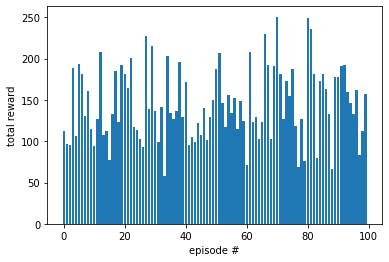

In [21]:
from stable_baselines3 import PPO

env = BatteryStorageInGridEnv()

# model = PPO("MultiInputPolicy", env, verbose=1)
# model.learn(total_timesteps=200000)
# model.save("ppo_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = PPO.load("ppo_single_agent_battery_env")

episodes = 100

rewards_lst_4 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_4.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_4)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()